# Automatic Image Captioning

### Project-1, Group-2: 

- KNS Pavan Kumar
- Nandan Kumar
- Chaitanya Kaushik

# 1. Import Modules

In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
import pickle as pkl
import collections

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from PIL import Image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

# 2. Loading Captions File

In [ ]:
# Reading the Description file

with open(r"C:/Users/DYSL-SM/Desktop/image_caption/Flickr_Text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [ ]:
captions = captions.split("\n")[:-1]

In [ ]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

# 3. Cleaning the Captions File

In [ ]:
''' 
For the following function 

Input     : String

Operations: (1) Lower each word
            (2) Remove puntuations
            (3) Remove words less than length 1 

Output    : New cleaned-string 

'''

def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ",sample)
    sample = sample.split()
    sample = [s for s in sample if len(s)>1]
    sample = " ".join(sample)
    
    return sample

In [ ]:
#Descriptions before cleaning. Taking the first image ('667626_18933d713e') in the Flicker data set for checking

descriptions['667626_18933d713e']

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 'A young girl is lying in the sand , while ocean water is surrounding her .',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [ ]:
# Each caption in the Descriptions file is cleaned 

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [ ]:
# Descriptions after cleaning. Taking the first image ('667626_18933d713e') in the Flicker data set for checking

descriptions['667626_18933d713e']

['girl is stretched out in shallow water',
 'girl wearing red and multi colored bikini is laying on her back in shallow water',
 'little girl in red swimsuit is laying on her back in shallow water',
 'young girl is lying in the sand while ocean water is surrounding her',
 'girl wearing bikini lying on her back in shallow pool of clear blue water']

In [ ]:
'''
The Descriptions are written to a text file so that immediately 
they can be summoned in other codes 

w - write 
r - read

Output Storage: The descriptions.txt file gets stored in the same folder 
                in which your Python Notebook is stored in Jupyter


'''

# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

#  reading description file

f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

# 4. Finding Vocabulary for Descriptions

In [ ]:
# finding the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [ ]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))

Vocabulary Size: 373837


In [ ]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

counter= collections.Counter(all_vocab)
dic_ = dict(counter)
threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]
print(len(all_vocab))

1845


# 5. Loading Train & Test Captions Data

In [ ]:
# Train Images Text Data

f = open(r"C:/Users/DYSL-SM/Desktop/image_caption/Flickr_Text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [ ]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [ ]:
# Test Images Text Data

f = open(r"C:/Users/DYSL-SM/Desktop/image_caption/Flickr_Text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [ ]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [ ]:
# Creating train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# adding Starting & Ending sequence for better extraction of the sentences

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [ ]:
# Taking the first image ('667626_18933d713e') in the Flicker data set for checking

train_descriptions['667626_18933d713e']

['startseq girl is stretched out in shallow water endseq',
 'startseq girl wearing red and multi colored bikini is laying on her back in shallow water endseq',
 'startseq little girl in red swimsuit is laying on her back in shallow water endseq',
 'startseq young girl is lying in the sand while ocean water is surrounding her endseq',
 'startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq']

# 6. Defining the Pre-Trained Model

In [ ]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
'''
ResNet50 which is a pre-trained model is being used for extraction of features. 
The last layer of ResNet50 performs classification and hence the last layer is 
to be removed 
'''

# Creating a new model by removing the last layer from the resnet50


model_new = Model(model.input, model.layers[-2].output)

# 7. Image Preprocessing & Feature Extraction

In [ ]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
images = "./flicker8k-dataset/Flickr8k_Dataset/"

encoding_train = {}
encoding_test = {}

# ==========================================================================
# Extracting the Image Features from the Training Set

for ix, img in enumerate(train):
    
    img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)

# Saving the Training Image Features as Binary File

with open("./storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

with open("encodin_train_features.pkl","rb") as f:
    encoding_train=pkl.load(f)

# ==========================================================================
# Extracting the Image Features from the Testing Set

for ix, img in enumerate(test):

    img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)

# Saving the Testing Image Features as Binary File

with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

# ==========================================================================
# Loading the Feature Files
    
with open("./encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

with open("encoded_test_features.pkl","rb") as f:
    encoding_test=pkl.load(f)

# Load the test images features from disk

with open("./storage/encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

# 8. Mapping words to Integers

In [ ]:
'''
Totally 1845 unique words are there. Each word is to be assigned with an integer 
so that the pattern can be generated. word_to_idx is mapping between each unique 
word in all_vocab to int value and idx_to_word is vice-versa

Even the startseq and endseq needs to be assigned values

'''


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

# Assigning integers to Start & End Sequence 
    
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

# Vocabulary Size = len + 1 (0 also appended)

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [ ]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


# 9. Data Preparation using Generator Function

In [ ]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                u = np.array(X1)
                v = np.array(X2)
                w = np.array(y)
                yield ([u,v],w)
                X1, X2, y = [], [], []
                n=0

# 10. Using pretrained Word Embeddings from Glove

In [ ]:
f = open("C:/Users/DYSL-SM/Desktop/image_caption/glove6b/glove_6B_50d.txt", encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

### Converting words into vectors

In [ ]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [ ]:
embedding_output.shape

(1848, 50)

# 11. Model Architecture & Training

In [ ]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [ ]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=10, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

tf.config.experimental_run_functions_eagerly(True)

In [ ]:
model = load_model("model_9.h5")

# 12. Predictions on Test Set

In [ ]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [ ]:
#Defining the Image Path

img_path='C:/Users/DYSL-SM/Desktop/image_caption/Flickr_Images'

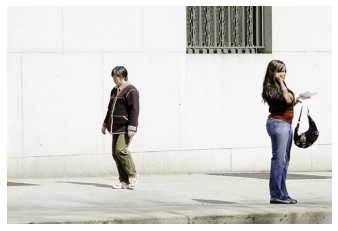

man in blue shirt and jeans is standing in front of some people


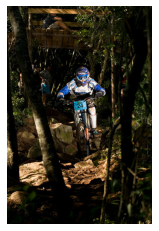

man on bike is riding his bike through the woods


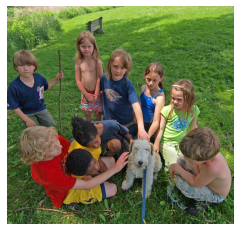

two children are sitting in bed


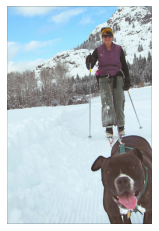

black dog is running through the snow


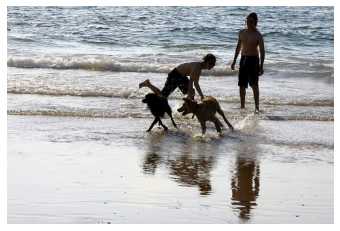

two people are walking on the beach


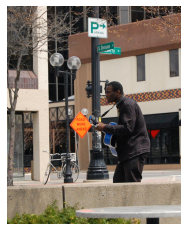

man in black shirt and jeans is walking past the street


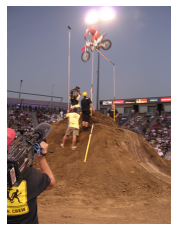

man in blue shirt and black shorts is jumping over rock


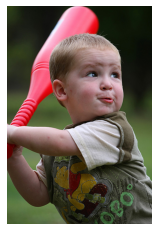

girl in purple shirt is holding up her nose


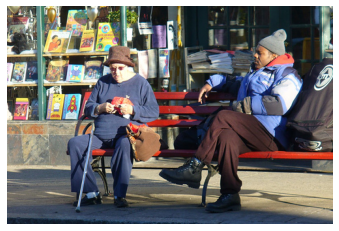

man in red shirt and black hat is standing in front of crowd


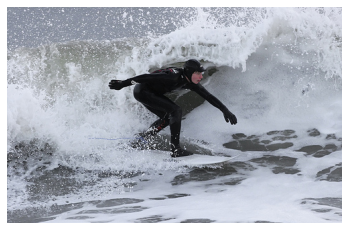

surfer in wetsuit is riding wave


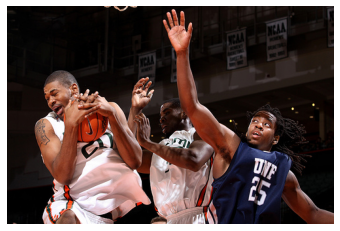

two men in white and white are playing basketball


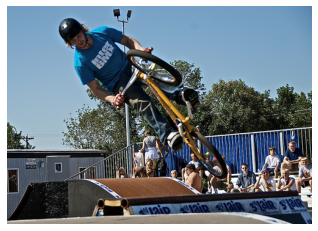

man in green shirt and jeans is jumping into the air


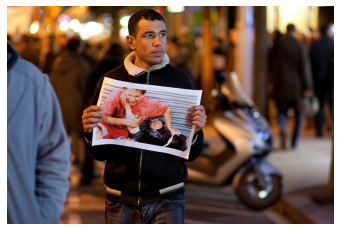

woman in black shirt and tie and black hat is standing in front of crowd


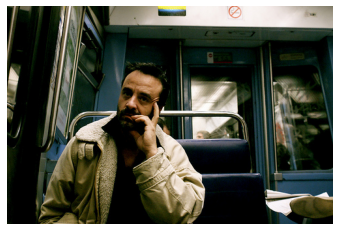

man with glasses and woman in black


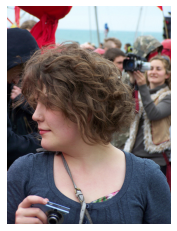

woman with camera is wearing black bandanna


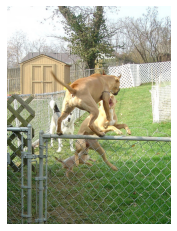

dog jumping over hurdle


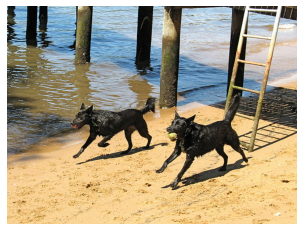

two dogs are running on the beach


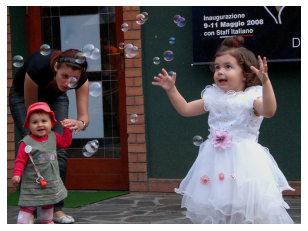

group of people are standing in front of some adults


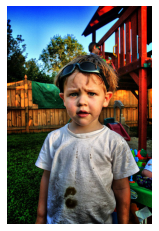

boy in red shirt and blue jeans is holding the wheel of another boy in blue shirt


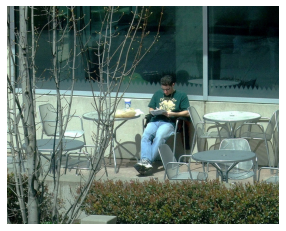

man in black shirt and jeans is sitting on bench in front of some houses


In [ ]:
for i in range(20):
    num =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[num]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(img_path+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    
    print(caption)

# 13. Checking the Metrics: BLEU Score

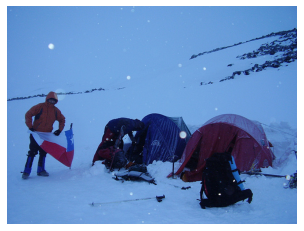

Cumulative 1-gram:0.636
Cumulative 2-gram:0.437
man holds flag next to snowbound campsite
man in red and white coat is standing in the snow


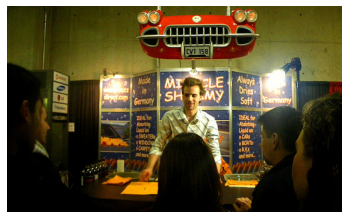

Cumulative 1-gram:0.143
Cumulative 2-gram:0.000
blonde haired man is doing demonstration in front of small crowd of people
man with woman sit on the subway


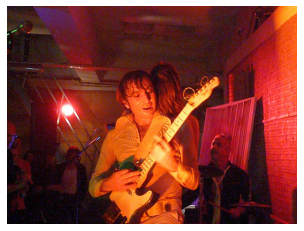

Cumulative 1-gram:0.231
Cumulative 2-gram:0.139
man in fancy clothing plays guitar on stage
man in red shirt and white shirt is standing in crowd of people


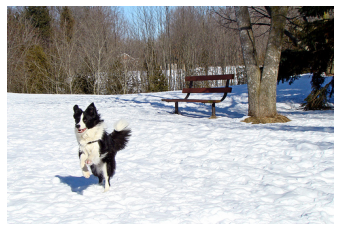

Cumulative 1-gram:0.250
Cumulative 2-gram:0.000
black and white dog is jumping in the snow at park
two dogs are running through snow covered field


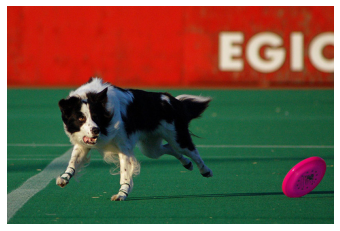

Cumulative 1-gram:0.564
Cumulative 2-gram:0.437
black and white dog chases pink frisbee
dog is running on the grass


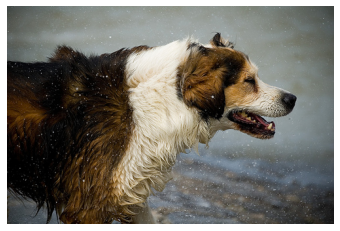

Cumulative 1-gram:0.778
Cumulative 2-gram:0.697
brown and white dog stands outside while it snows
brown and white dog is standing in the water


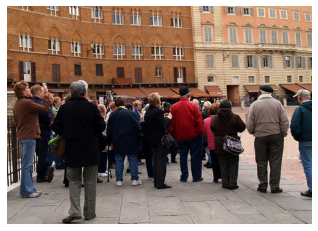

Cumulative 1-gram:0.619
Cumulative 2-gram:0.518
crowd of people are standing in front of italian style buildings
people stand outside in front of building


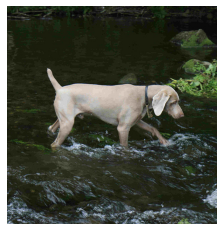

Cumulative 1-gram:0.556
Cumulative 2-gram:0.264
dog is trotting through shallow stream
dog is playing with tennis ball in the water


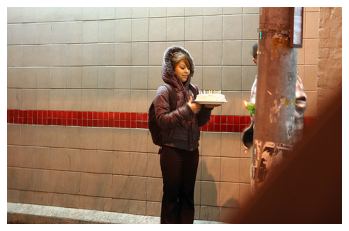

Cumulative 1-gram:0.000
Cumulative 2-gram:0.000
girl in hooded jacket presents cake with candles
group of people sit on bench


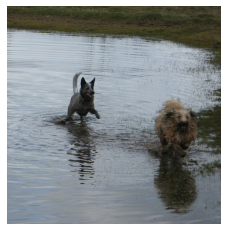

Cumulative 1-gram:0.833
Cumulative 2-gram:0.408
grey dog chasing brown dog in shallow water
two dogs running in the water


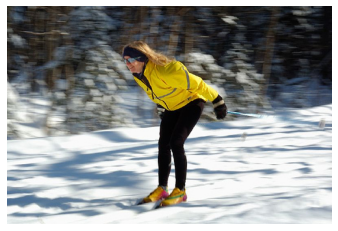

Cumulative 1-gram:0.500
Cumulative 2-gram:0.236
woman in yellow and black outfit is skiing
child in red jacket and helmet is running through snow


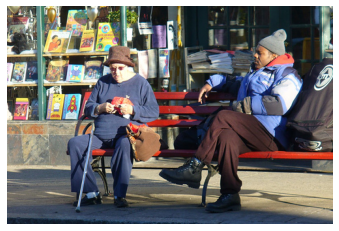

Cumulative 1-gram:0.538
Cumulative 2-gram:0.300
an older man is sitting on red bench with younger man
man in red shirt and black hat is standing in front of crowd


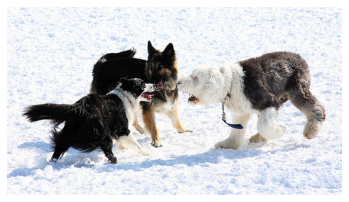

Cumulative 1-gram:0.667
Cumulative 2-gram:0.408
group of dogs look at each other while standing in the snow
two dogs are playing with ball in the snow


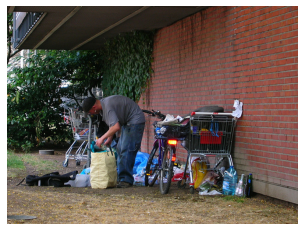

Cumulative 1-gram:0.545
Cumulative 2-gram:0.330
man fiddles with shopping bag outside near shopping cart
man in black shirt and tie is walking past the street


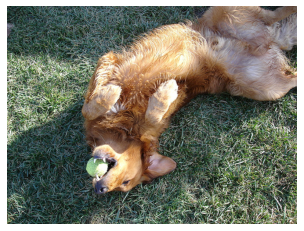

Cumulative 1-gram:0.327
Cumulative 2-gram:0.244
brown dog is laying on its back on the grass with ball in its mouth
two dogs are playing with each other in the grass


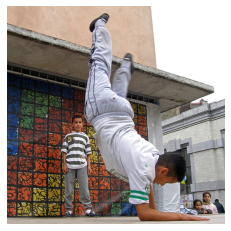

Cumulative 1-gram:0.600
Cumulative 2-gram:0.258
boy in white tracksuit is break dancing on the ground in front of colorful wall
man in black shirt and jeans is standing on bench


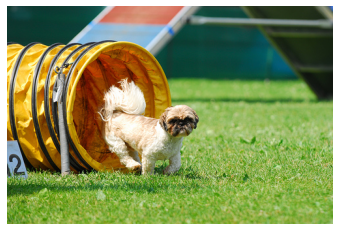

Cumulative 1-gram:0.118
Cumulative 2-gram:0.000
dog coming out of large yellow tube
dog jumping over hurdle


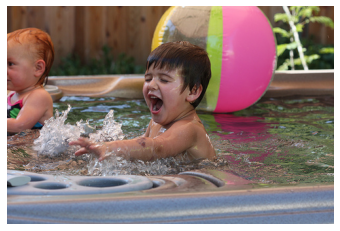

Cumulative 1-gram:0.500
Cumulative 2-gram:0.000
boy with beach ball behind him playing in pool
little boy in blue shirt is playing with multi inflatable


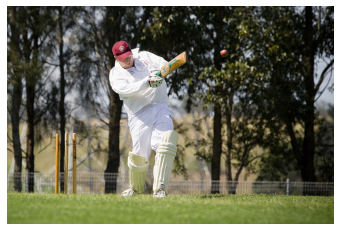

Cumulative 1-gram:0.500
Cumulative 2-gram:0.302
cricket batter dressed all in white makes hit
girl in red shirt and blue shorts is running on the grass


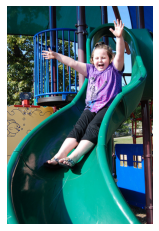

Cumulative 1-gram:0.500
Cumulative 2-gram:0.333
little girl slides down green slide with her arms up at playground
little girl in orange shirt is going down slide slide


In [ ]:
for i in range(20):
    num =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[num]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(img_path+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    
#     for i in range(5):
    BLEUscore=0
    reference1=descriptions[img_name][0].split()
    reference2=descriptions[img_name][1].split() 
    reference3=descriptions[img_name][2].split() 
    reference4=descriptions[img_name][3].split() 
    reference5=descriptions[img_name][4].split() 
    hypothesis=caption.split()
    BLEUscore1 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(1, 0, 0, 0))
    BLEUscore2 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(0.5, 0.5, 0, 0))
    BLEUscore3 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(0.33, 0.33, 0.33, 0))
    BLEUscore4 = nltk.translate.bleu_score.corpus_bleu([[reference1,reference2,reference3,reference4,reference5]], [hypothesis], weights=(0.25, 0.25, 0.25, 0.25))
    
    print("Cumulative 1-gram:%.3f"%BLEUscore1)
    print("Cumulative 2-gram:%.3f"%(BLEUscore2))
    print(descriptions[img_name][0])
    print(caption)